# **House prices**
Ames Housing Dataset
***
This is *NOT* the finished version of the notebook, it is not a rigorous approach. 
- EDA has been done. A more complete analysis can still be done
- Missing values are not deleted, they are filled depending on the column data type
- No feature selection yet
- Used GradientBoostingRegressor(tunned), LassoCV,RidgeCV and ElasticNetCV <br>

**To be done:**
- A more rigorous EDA
- Imputations, Feature Extraction, Feature Selection
- Transformations
- New models

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso,Ridge,LassoCV,RidgeCV,ElasticNetCV
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RepeatedKFold


import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.simplefilter('ignore',FutureWarning)
pd.set_option("precision", 6)
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# Import dataset
# We drop the id column for both train and test

train = pd.read_csv('data/train.csv').drop('Id',axis=1) 
test = pd.read_csv('data/test.csv')
id_test = test.Id.copy() 
test.drop('Id',axis=1,inplace=True)
print('Train Shape:',train.shape)
train.head(2)

Train Shape: (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### The data [documentation](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) says that there are 5 observations considered outliers, we will delete them

[]

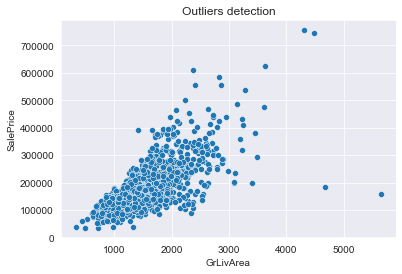

In [3]:
# We plot the outliers

sns.scatterplot(train.GrLivArea,train.SalePrice)
plt.title('Outliers detection')
plt.plot()

In [4]:
# We delete the outliers
outliers = train.GrLivArea.nlargest(5).index
train = train.drop(outliers,axis=0)
train.shape

(1455, 80)

## Missing values analysis

In [5]:
# We check how many columns have null values
train.isnull().any().sum()

19

In [6]:
# Which columns have null values
null_cols = train.columns[train.isnull().sum() > 0]
null_cols

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

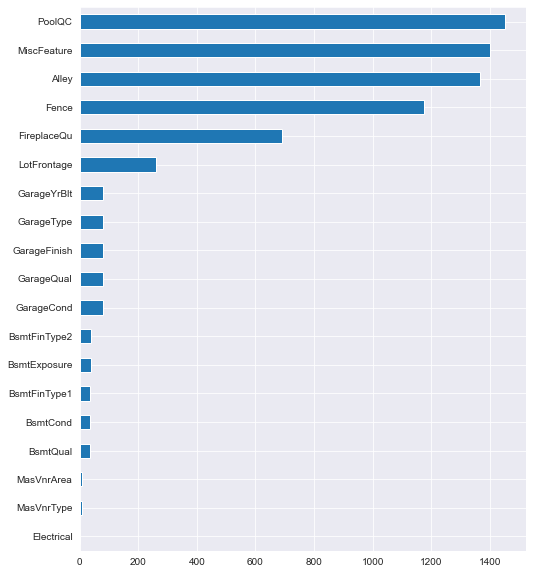

In [7]:
# What columns have more missing values
plt.figure(figsize=(8,10))
train[null_cols].isnull().sum().sort_values().plot(kind='barh')
plt.show()

### Columns can be dropped or combined. By now we will not do anything
- Some of them use nan to describe the absence of the quality. For example, in PoolQC nans are used when the house has no pool <br>


***
## Explore sales 

In [8]:
# We include the skewness and the kurtosis in our analysis
sale_stats = pd.DataFrame(train.SalePrice.describe())
for i in [train.SalePrice.skew(),train.SalePrice.kurt()]:
    sale_stats = sale_stats.append({'SalePrice':i},ignore_index=True)
sale_stats.index = list(train.SalePrice.describe().index) + ['Skew','Kurt']
# It is skewed
sale_stats

,SalePrice
count,1455.000000
mean,179845.495533
std,75830.196527
min,34900.000000
25%,129900.000000
50%,163000.000000
75%,213750.000000
max,611657.000000
Skew,1.494437
Kurt,3.416806


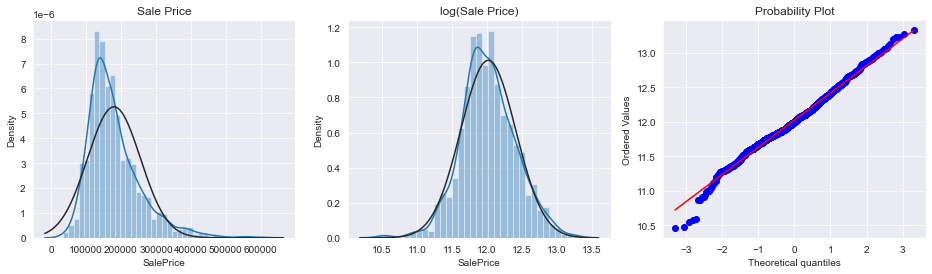

In [9]:
# there are signs of lognormallity or a similar distribution
y = train.SalePrice

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))

ax1.set_title('Sale Price')
sns.distplot(y,kde=True,ax=ax1,fit=st.norm)

# We apply log to sales
# Now is normal

ax2.set_title('log(Sale Price)')
sns.distplot(np.log(y),kde=True,ax=ax2,fit=st.norm)

st.probplot(np.log(y),plot=plt)  # after applying log to sales

plt.show()

### Create X and y

In [10]:
X = train[train.columns.difference(['SalePrice'])]
y = np.log(train.SalePrice)   # we take the log of SalePrice

## We explore the features
***
#### Let's see correlations. Both Pearson and Spearman.

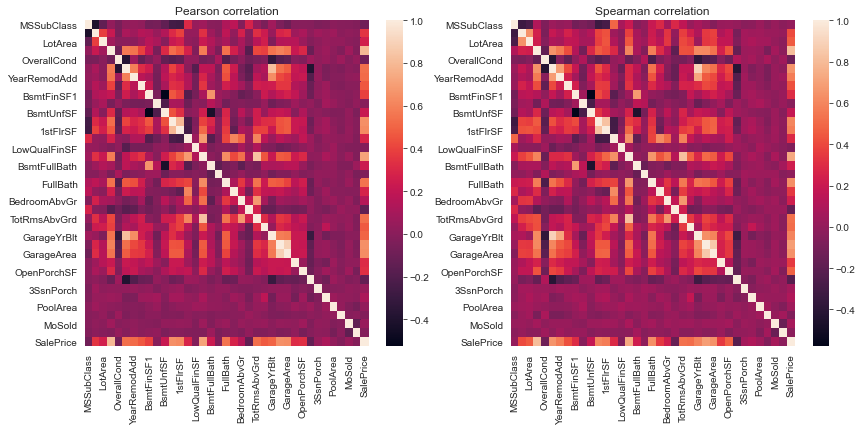

In [11]:
corr_1 = train.corr()
corr_2 = train.corr('spearman')
f,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
sns.heatmap(corr_1,ax=ax1)
ax1.set_title('Pearson correlation')
sns.heatmap(corr_2,ax=ax2)
ax2.set_title('Spearman correlation')
plt.show()

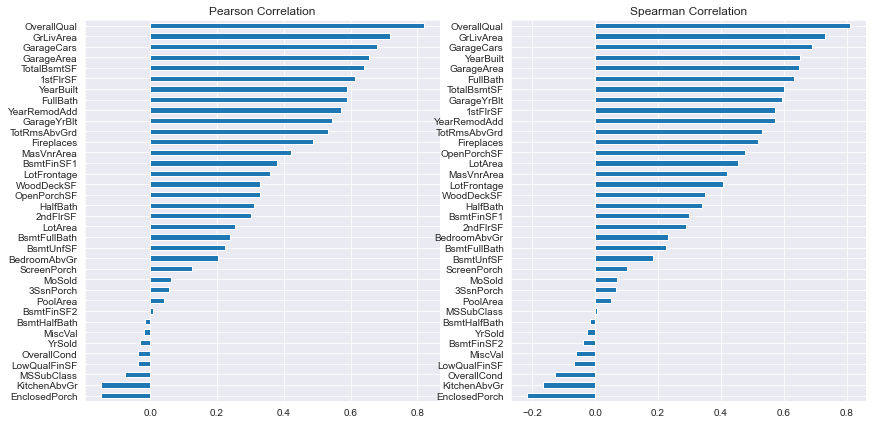

In [12]:
# Corrlation between log(SalePrice) and the predictors
f = plt.figure(figsize=(14,7))
f.add_subplot(1,2,1)
X.corrwith(y).sort_values(ascending=True).plot(kind='barh',label='Pearson')
plt.title('Pearson Correlation')

f.add_subplot(1,2,2)
X.corrwith(y,method='spearman').sort_values(ascending=True).plot(kind='barh')
plt.title('Spearman Correlation')

plt.show()

### Let's start with continuous features

In [13]:
# Lets get them
cont_feat = X.select_dtypes([np.number]).columns
print(f'Continuous features: {len(cont_feat)}')
cont_feat

Continuous features: 36


Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

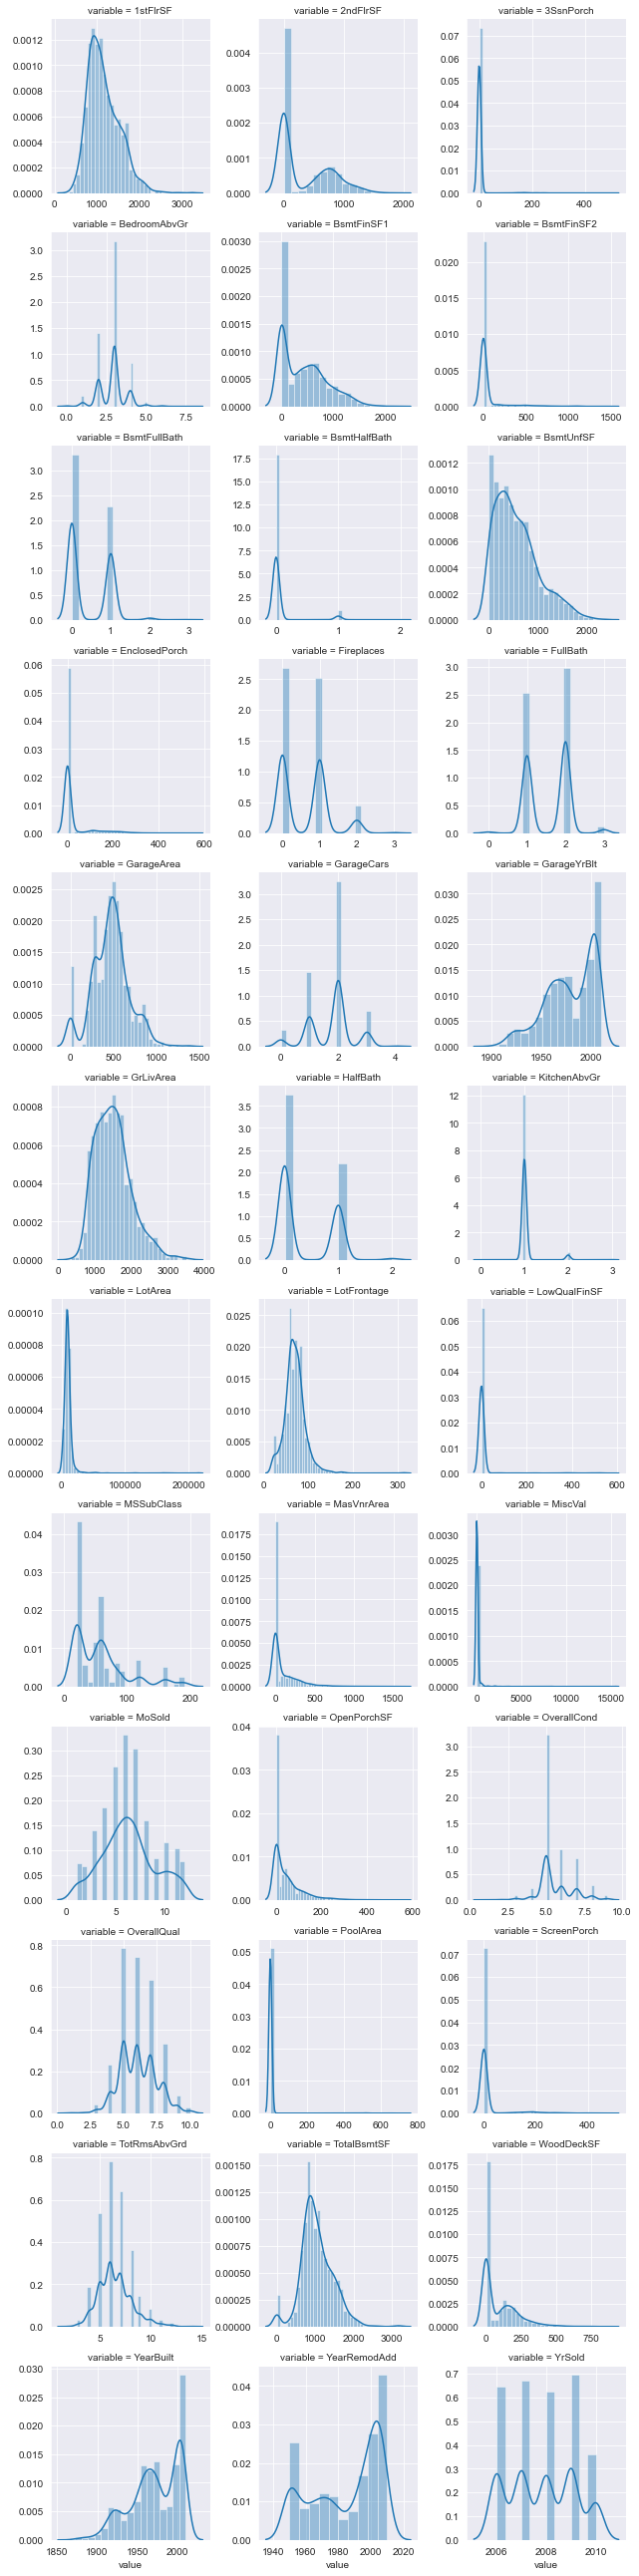

In [14]:
# we plot these variables
melt = pd.melt(X,value_vars=cont_feat)
g = sns.FacetGrid(melt,col='variable',col_wrap=3,sharex=False, sharey=False,height=3)
g = g.map(sns.distplot,'value')

####  It is clear that some of the above variables are discrete
#### Some of them can be transformed

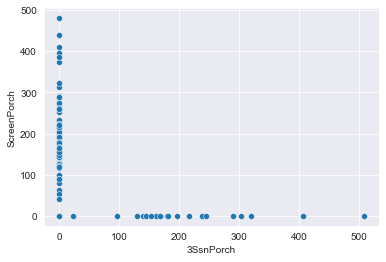

In [15]:
# These 2 features can be combined in a 'Porch' feature
sns.scatterplot(data=X,x='3SsnPorch',y='ScreenPorch')
plt.show()

### let's do a bivariate analysis

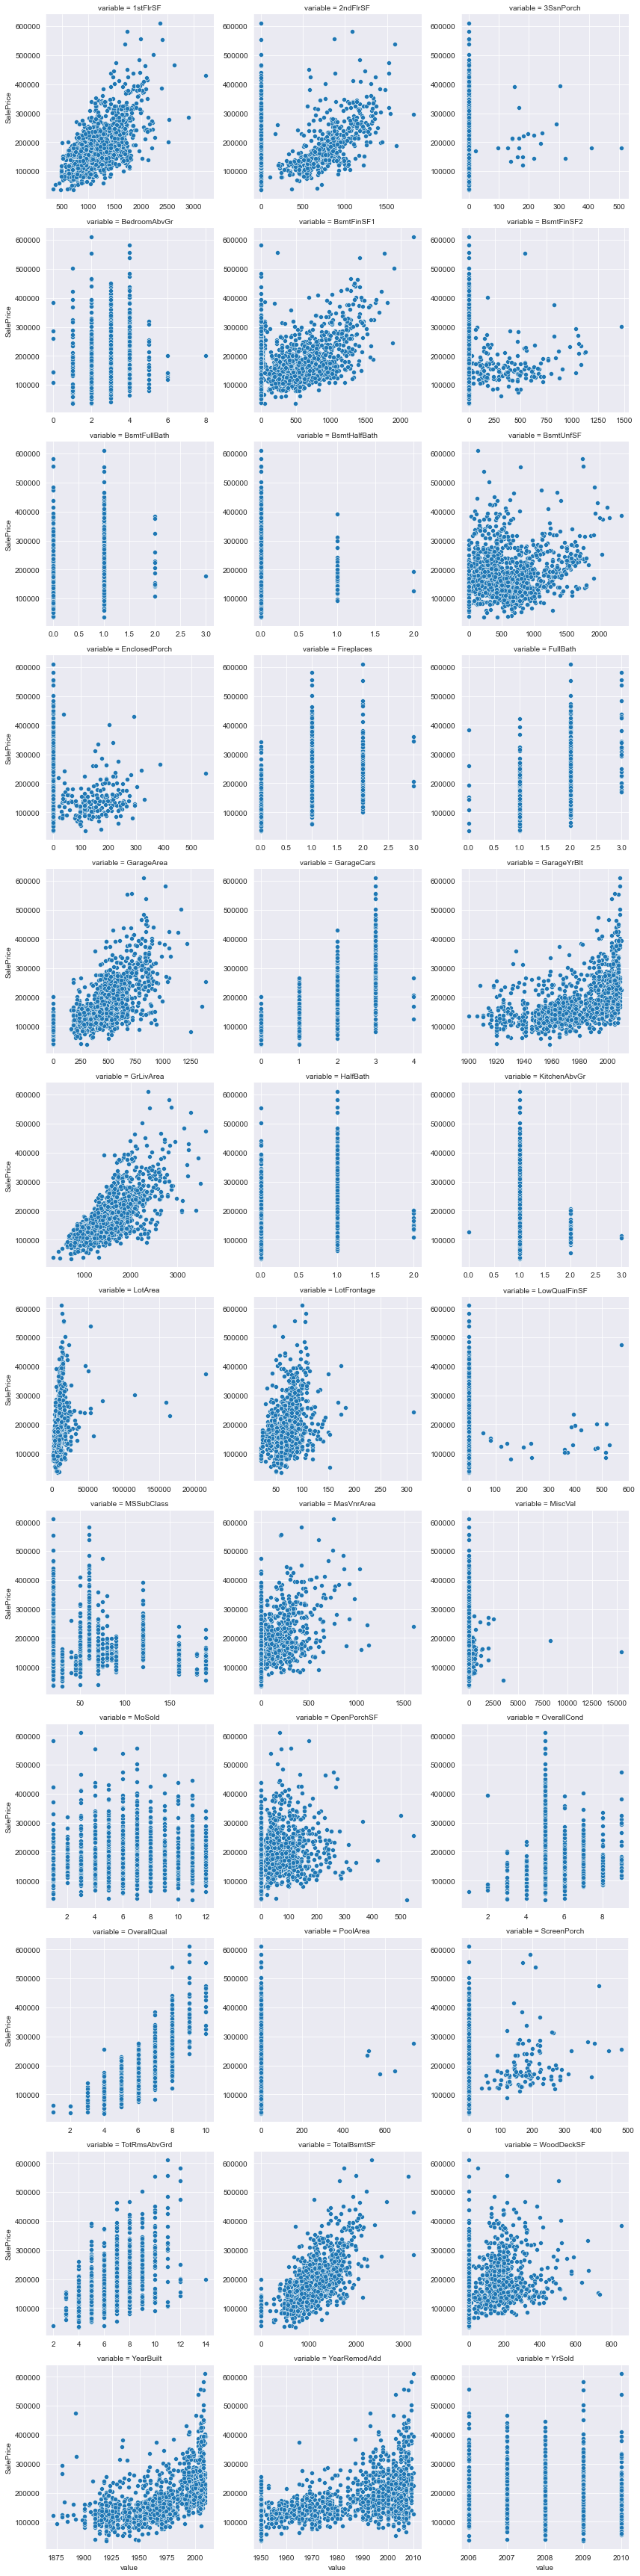

In [16]:
melt = pd.melt(train, id_vars=['SalePrice'], value_vars=cont_feat)
g = sns.FacetGrid(melt, col="variable",  col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.scatterplot, "value", "SalePrice")

## Categorical features

In [17]:
# Categorical features
cat_feat = cont_feat = X.select_dtypes('object').columns
print(f'Categorical features: {len(cat_feat)}')
cat_feat

Categorical features: 43


Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [18]:
## we can change the dtype to categorical
X[X.select_dtypes(['object']).columns] = X.select_dtypes(['object']).astype('category')

# the same to test
test[test.select_dtypes(['object']).columns] = test.select_dtypes(['object']).astype('category')

C:\Users\jinci\Anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


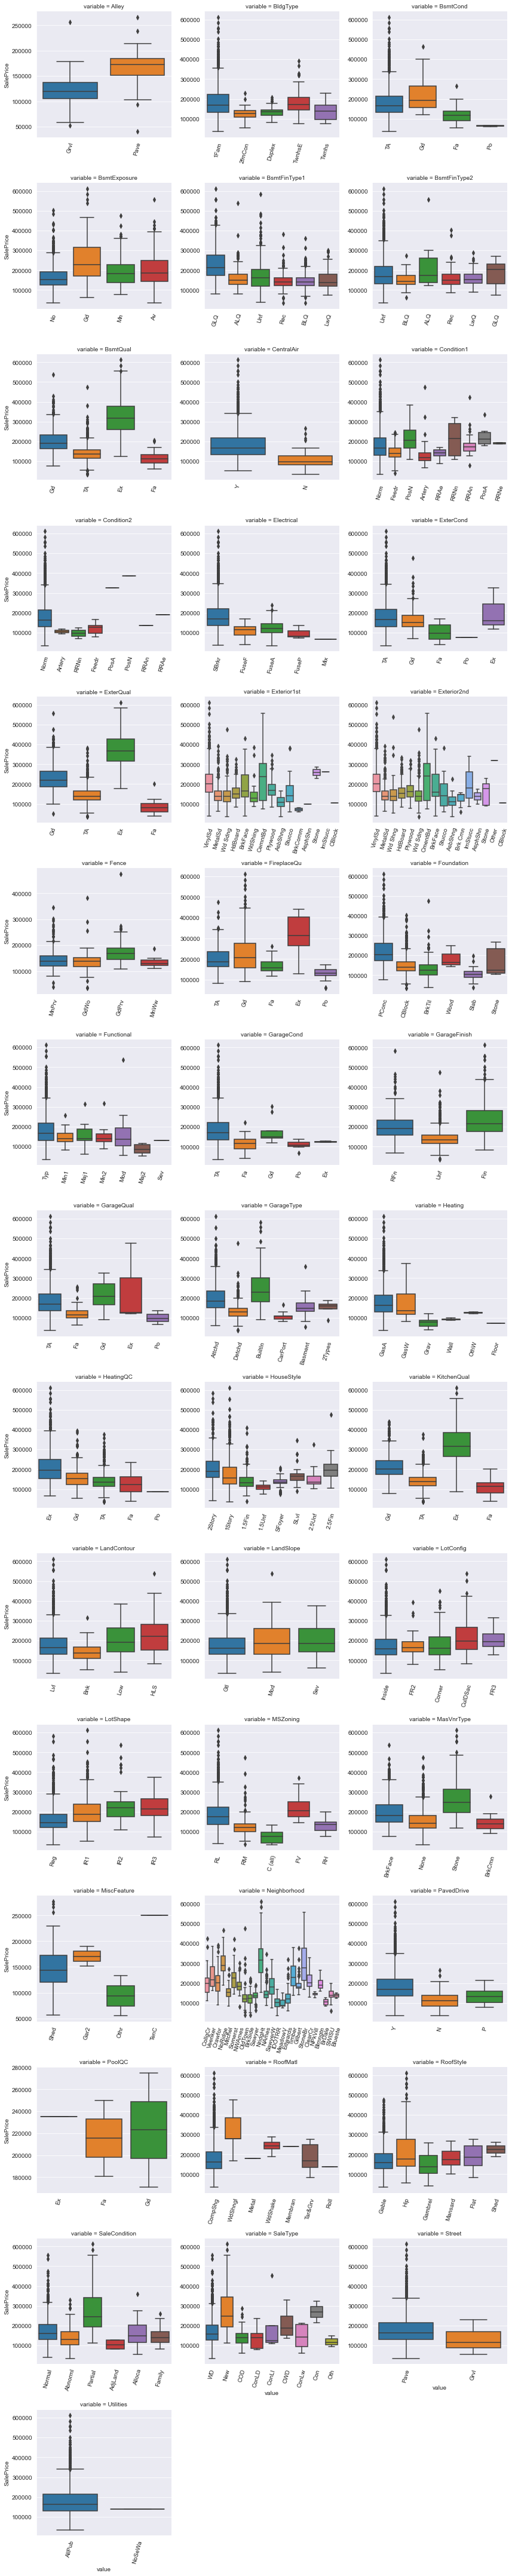

In [19]:
# let's do a bivariate analysis

def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    plt.xticks(rotation=75)
    
melt = pd.melt(train, id_vars=['SalePrice'], value_vars=cat_feat)
g = sns.FacetGrid(melt, col="variable",  col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(boxplot, "value", "SalePrice")

# **Modelling**

# Build a pipeline
- We wil build a pipeline that will preprocess the data and use GradientBoostingRegressor as model

In [20]:
# We create a preprocessor

# numerical
num_transf = Pipeline([('imputer',SimpleImputer(strategy='median')), # we fill with the median
                      ('scaler',StandardScaler())])

#categorical
cat_transf = Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='none')), # we do nothing with nans by now
                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

# All together
ct = make_column_transformer((num_transf,
                              make_column_selector(dtype_include=np.number)),    #continuous
                            (cat_transf,
                             make_column_selector(dtype_include='category')))    # categorical

## GradientBoostingRegressor

In [21]:
## GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=160)
pipe = Pipeline([('pre',ct),
                ('model',gbr)])
pipe.fit(X,y)

# Params 

subsample = list(np.linspace(0.3,1,4))
min_sample_leaf = [1,3,6]
max_features = ['auto','sqrt']
max_depth = [2,3]

params = {'model__max_features':max_features,'model__subsample':subsample,
          'model__min_samples_leaf':min_sample_leaf,'model__max_depth':max_depth}

# GridSearch
inner = KFold(shuffle=True)
grid = GridSearchCV(pipe,params,scoring='neg_mean_squared_error',cv=inner)

In [22]:
# we fit the pipe
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002DED1B5B788>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=...
                   

In [23]:
# We save the best model from GridSearch
grid_params = grid.best_params_
keys = ['max_depth','max_features','min_samples_leaf','subsample']
values = grid_params.values()
params = {key:value for key,value in zip(keys,values)}
params['n_estimators']=160

In [24]:
# We define a function to estimate the true performance of our model given the tunned hyperparameters
# If we wanted to perform nested CV this function would work

def mse_model(model,n_repeats,n_splits,random_state,params=None):
    model = model.set_params(**params) if params else model
    pipe = Pipeline([('pre',ct),
                ('model',model)])
    fold = RepeatedKFold(n_repeats=n_repeats,n_splits=n_splits,random_state=random_state) # We use ReapeatedKFold so we have various trials
    outer = -cross_val_score(pipe,X,y,cv=fold,scoring='neg_mean_squared_error') # we want to estimate the true performance
    print(f'The CV MSE is {outer.mean():.6f}')
    print(model)
    return outer.mean()

In [25]:
## We estimate the true performance of the model

gbr = GradientBoostingRegressor(**params)
mse_model(gbr,3,4,0)


The CV MSE is 0.014837
GradientBoostingRegressor(max_features='auto', min_samples_leaf=6,
                          n_estimators=160, subsample=0.7666666666666666)


0.014836590661777234

***
## **Trying new models**


### Lasso

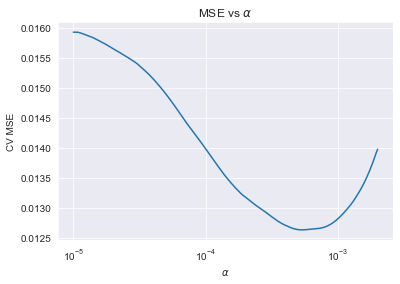

The value of alpha is: 0.0005273640886351335


In [26]:
## Lets try with Lasso
alphas = np.logspace(-5,-2.7,200)
lasso = LassoCV(alphas=alphas)
pipe = Pipeline([('pre',ct),
                ('model',lasso)])
pipe.fit(X,y)

## We plot  MSE vs alpha

pipe_alphas = pipe.named_steps.model.alphas_
pipe_mse = pipe.named_steps.model.mse_path_

# The plot
plt.plot(pipe_alphas,pipe_mse.mean(axis=1))
plt.title(r'MSE vs $\alpha$ ')
plt.xlabel(r'$\alpha$')
plt.xscale('log')
plt.ylabel('CV MSE')
plt.show()
best_alpha = pipe.named_steps.model.alpha_
print('The value of alpha is:',best_alpha)

In [27]:
## lets see how the model performs
# We use the new best alpha
mse_model(Lasso(),3,4,0,{'alpha':best_alpha})

The CV MSE is 0.012783
Lasso(alpha=0.0005273640886351335)


0.012782803146201553

### Ridge

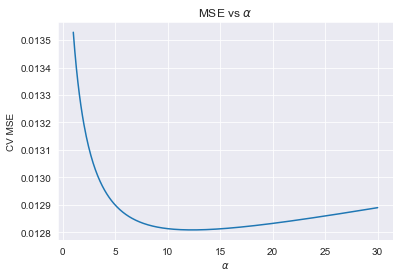

The value of alpha is: 12.338345864661653


In [29]:
## Lets try with Ridge
alphas = np.linspace(1,30,400)
ridge = RidgeCV(alphas=alphas,store_cv_values=True)
pipe = Pipeline([('pre',ct),
                ('model',ridge)])
pipe.fit(X,y)

# We plot  MSE vs alpha

pipe_mse = pipe.named_steps.model.cv_values_
plt.plot(alphas,pipe_mse.mean(axis=0))
plt.title(r'MSE vs $\alpha$ ')
plt.xlabel(r'$\alpha$')
plt.ylabel('CV MSE')
plt.show()
best_alpha = pipe.named_steps.model.alpha_
print('The value of alpha is:',best_alpha)


In [30]:
# The CV score of our best model
mse_model(Ridge(),3,4,0,{'alpha':best_alpha})

The CV MSE is 0.013249
Ridge(alpha=12.338345864661653)


0.013248742097100233

## Elastic net
No good results. Did not find a good combination of l1 and l2

The best value of alpha is: 0.0005260696469088064
The best l1_ratio is: 1.0


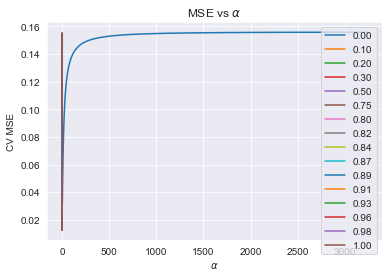

In [32]:
## Lets try with ElasticNet

ratios = [0.0001,0.1,0.2,0.3,0.5,0.75] + list(np.linspace(0.80,1,10))
el_net = ElasticNetCV(l1_ratio=ratios,max_iter=10000)
pipe = Pipeline([('pre',ct),
                ('model',el_net)])
pipe.fit(X,y)

# We save these attributes in order to plot MSE vs alpha

pipe_alphas = pipe.named_steps.model.alphas_
pipe_mse = pipe.named_steps.model.mse_path_
 
# Best hyperparameters

best_alpha = pipe.named_steps.model.alpha_
l1_ratio = pipe.named_steps.model.l1_ratio_

# We plot MSE vs alpha

for i,ratio in enumerate(ratios):
    plt.plot(pipe_alphas[i,:],pipe_mse.mean(axis=2)[i,:],label = f'{ratio:.2f}')
    plt.title(r'MSE vs $\alpha$')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('CV MSE')
    plt.legend()

print('The best value of alpha is:',best_alpha)
print('The best l1_ratio is:',l1_ratio)